In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
import sys
import time
import pickle
import json
import h5py

In [2]:
def simulate(monkey, session, block):
    params = get_params(monkey, session, block)
    net = build_network(params)
    sim = nengo.Simulator(net)
    with sim:
        for trial in range(1, params['n_trials']):
            reset_nodes(net, params, trial)
            net.act.set(False)
            sim.run(params['t_iti'])
            set_nodes(net, params, trial)
            sim.run(params['t_cue'])
            net.act.set(True)
            sim.run(params['t_rew'])
        # data = get_data(sim, net)
    return sim, net

In [3]:
def get_params(monkey, session, block):
    params = {
        'monkey':monkey,
        'session':session,
        'block':block,
        'n_trials':3,
        'seed_net':0,
        'seed_rew':0,
        't_iti':0.33,
        't_cue':0.34,
        't_rew':0.33,
        'p_rew':1.0,
        'w0':0.5,
        'lr_let':3e-5,
        'lr_loc':3e-5,
        'lr_w':3e-5,
        'ramp':0.2,
        'alpha_v':0.5,
        'gamma_v':0.8,
        'alpha_w':0.4,
        'gamma_w':0.1,
        'neurons':2000,
    }
    return params

In [4]:
def set_nodes(net, params, trial):
    net.cue.set(trial)
    net.mask_learn.set(trial)
    net.mask_decay.set(trial)
    net.rew.set(trial)

def reset_nodes(net, params, trial):
    net.cue.reset()
    net.mask_learn.reset()
    net.mask_decay.reset()

In [5]:
def build_network(params):
                
    class CueNode(nengo.Node):
        def __init__(self, params, size_in=0, size_out=2):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='cue')
        def set(self, trial):
            # [1,0] if [A,B]  or  [0,1] if [B,A], serves as a mask for value routing in the network
            self.state[0] = 1 if self.emp.query("trial==@trial")['left'].values[0]=='A' else 0
            self.state[1] = 1 if self.emp.query("trial==@trial")['right'].values[0]=='A' else 0
        def reset(self):
            self.state = np.zeros((self.size_out))
        def step(self, t):
            return self.state

    class ActionNode(nengo.Node):
        def __init__(self, params, size_in=2, size_out=1):
            self.choose = False
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='action')
        def set(self, choose):
            self.choose = choose
            self.state = np.zeros((self.size_out))
        def step(self, t, x):
            aL, aR = x[0], x[1]
            if self.choose:
                if aL>aR: self.state[0] = 1
                elif aR>aL: self.state[0] = -1
                else: self.state[0] = 0
            return self.state

    class RewardNode(nengo.Node):
        def __init__(self, params, size_in=1, size_out=2):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.p_rew = params['p_rew']
            self.rng = np.random.default_rng(seed=params['seed_rew'])
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.correct = None
            self.deliver = None
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='reward')
        def set(self, trial):
            self.correct = self.emp.query("trial==@trial")['correct'].values[0]
            self.deliver = self.rng.uniform(0,1) <= self.p_rew
        def step(self, t, x):
            action = x[0]
            if action==0:
                self.state[0] = 0
                self.state[1] = 1
            else:
                correct = 1 if self.correct=='left' else -1
                if action==correct and self.deliver: self.state[0] = 1  # yes rewarded for picking the better option
                if action==correct and not self.deliver: self.state[0] = -1  # not rewarded for picking the better option
                if action!=correct and not self.deliver: self.state[0] = 1  # yes rewarded for picking the worse option
                if action!=correct and self.deliver: self.state[0] = -1  # not rewarded for picking the worse option
                self.state[1] = 1 - np.abs(self.state[0])  # 1 unless an action has beeh chosen and reward is being delivered
            return self.state

    class MaskLearningNode(nengo.Node):
        def __init__(self, params, size_in=1, size_out=4):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.letter_left, self.letter_right = None, None
            self.left_letter, self.right_letter = None, None
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='mask_learn')
        def set(self, trial):
            self.left_letter = 1 if self.emp.query("trial==@trial")['left'].values[0]=='A' else -1
            self.right_letter = 1 if self.emp.query("trial==@trial")['right'].values[0]=='A' else -1
        def reset(self):
            self.left_letter, self.right_letter = None, None
        def step(self, t, x):
            action = x[0]  # 1 if left is chosen, -1 if right is chosen
            self.state = np.zeros((self.size_out))
            self.state[0] = 1 if (action==1 and self.left_letter==1) or (action==-1 and self.right_letter==1) else 0
            self.state[1] = 1 if (action==1 and self.left_letter==-1) or (action==-1 and self.right_letter==-1) else 0
            self.state[2] = 1 if action==1 else 0
            self.state[3] = 1 if action==-1 else 0
            return self.state
            # [vA, vB, vL, vR]: 1 if learning should occur because letter/loc was chosen, 0 otherwise

    class MaskDecayNode(nengo.Node):
        def __init__(self, params, size_in=1, size_out=4):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.left_letter, self.right_letter = None, None
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='mask_decay')
        def set(self, trial):
            self.left_letter = 1 if self.emp.query("trial==@trial")['left'].values[0]=='A' else -1
            self.right_letter = 1 if self.emp.query("trial==@trial")['right'].values[0]=='A' else -1
        def reset(self):
            self.left_letter, self.right_letter = None, None
        def step(self, t, x):
            action = x[0]  # 1 if left is chosen, -1 if right is chosen
            self.state = np.ones((self.size_out))
            self.state[0] = 0 if (action==1 and self.left_letter==1) or (action==-1 and self.right_letter==1) else 0
            self.state[1] = 0 if (action==1 and self.left_letter==-1) or (action==-1 and self.right_letter==-1) else 0
            self.state[2] = 0 if action==1 else 0
            self.state[3] = 0 if action==-1 else 0
            return self.state
            # [vA, vB, vL, vR]: 1 if decay should occur because letter/loc was NOT chosen, 0 otherwise

    net = nengo.Network(seed=params['seed_net'])
    with net:
        # INPUTS
        in_f = nengo.Node([0,0,0,0])  # constant vector that provides features for learning values
        in_g = nengo.Node([0])  # constant vector that provides features for learning omega
        in_w = nengo.Node(params['w0'])  # baseline omega
        cue = CueNode(params)  # input trial-specific [Letter L, Letter R]
        rew = RewardNode(params)  # if action has been chosen, return trial-specific reward +/-1, and a generic reward signal: [signed_rew, abs_rew]
        mask_learn = MaskLearningNode(params)  # mask signal used to update the chosen values and locations: [mA, mB, mL, mR]
        mask_decay = MaskDecayNode(params)  # mask signal used to update the unchosen values and locations: [mA, mB, mL, mR] = 1 - mask_learn
        act = ActionNode(params)  # decides whether action values cross action threshold
        
        # ENSEMBLES
        f = nengo.Ensemble(params['neurons'], 4)  # value features
        g = nengo.Ensemble(params['neurons'], 1)  # omega features
        v = nengo.Ensemble(params['neurons'], 4, radius=2)  # learned values: [vA, vB, vL, vR]
        w = nengo.Ensemble(params['neurons'], 1)  # learned omega [w]
        a = nengo.Ensemble(params['neurons'], 2, radius=2)  # accumulated action values [aL, aR]
        r = nengo.Ensemble(params['neurons'], 2, radius=2)  # reset for action accumulation following choice [rL, rR]
        vlet = nengo.Ensemble(params['neurons'], 4, radius=2)  # learned values for letters, masked by letter location on current trial [vA, vB, mL, mR]
        vwa = nengo.Ensemble(params['neurons'], 5, radius=3)  # combined value and omega population: [vLetL, vLetR, vL, vR, w]
        evc = nengo.Ensemble(params['neurons'], 8, radius=4)  # combined error vector for chosen option and mask: [vA-E, vB-E, vL-E, vR-E, mA, mB, mL, mR]
        evu = nengo.Ensemble(params['neurons'], 8, radius=4)  # combined error vector for unchosn option and mask: [vA-E, vB-E, vL-E, vR-E, mA, mB, mL, mR]
        drel = nengo.Ensemble(params['neurons'], 8, radius=4)  # combined value vector for chosen option and mask, for updaing omega: [vA, vB, vL, vR, mA, mB, mL, mR]
        wtar = nengo.Ensemble(params['neurons'], 1)  # target omega value following action and reward  [wtar]
        ewt = nengo.Ensemble(params['neurons'], 1)  # error for omega update  [ew]
        ewd = nengo.Ensemble(params['neurons'], 1)  # error for omega decay  [ew]

        # CONNECTIONS
        # connect feature fectors to value populations and establish the learning connections
        nengo.Connection(in_f, f)
        nengo.Connection(in_g, g)
        cf = nengo.Connection(f[:2], v[:2], synapse=0.01, transform=0, learning_rule_type=nengo.PES(learning_rate=params['lr_let']))  # learned connection for letters
        cf2 = nengo.Connection(f[2:], v[2:], synapse=0.01, transform=0, learning_rule_type=nengo.PES(learning_rate=params['lr_loc']))  # learned connection for locations
        cg = nengo.Connection(g, w, synapse=0.01, function=lambda x: params['w0'], learning_rule_type=nengo.PES(learning_rate=params['lr_w']))  # learned connection for omega

        # combine all values and omega into one population
        nengo.Connection(v[:2], vlet[:2], synapse=0.01)  # [vA, vB]
        nengo.Connection(cue, vlet[2:4])  # [1,0] if [A,B] or [0,1] if [B,A], serves as a mask for value routing in the network
        nengo.Connection(vlet, vwa[0], synapse=0.01, function=lambda x: x[0]*x[2]+x[1]*x[3])  # computes vLetL using above mask
        nengo.Connection(vlet, vwa[1], synapse=0.01, function=lambda x: x[1]*x[2]+x[0]*x[3])  # computes vLetR using above mask
        nengo.Connection(v[2:4], vwa[2:4], synapse=0.01)  # [vL, vL]
        nengo.Connection(w, vwa[4], synapse=0.01)  # [w]

        # compute the overall action values using the arbitration weight
        nengo.Connection(vwa, a[0], synapse=0.01, transform=params['ramp'], function=lambda x: x[0]*x[4]+x[2]*(1-x[4]))  # vLetL*w + vL*(1-w)
        nengo.Connection(vwa, a[1], synapse=0.01, transform=params['ramp'], function=lambda x: x[1]*x[4]+x[3]*(1-x[4]))  # vLetR*w + vR*(1-w)

        # recurrent connect the action population so that it ramps at a rate proportional to the weighted values, then resets following choice
        nengo.Connection(a, a, synapse=0.1)
        nengo.Connection(a, r, synapse=0.01, transform=-1)
        nengo.Connection(r, a, synapse=0.1, transform=0.2)
        nengo.Connection(a, act, synapse=0.01)  # send action values to action node
        nengo.Connection(act, rew, synapse=None)  # send [+/-1] to reward node

        # compute error following choice and reward
        nengo.Connection(v, evc[:4], synapse=0.01)  # [vA, vB, vL, vR]
        nengo.Connection(rew[0], evc[:4], transform=4*[[-1]])  # [-rew, -rew, -rew, -rew]
        nengo.Connection(mask_learn, evc[4:8])  # [mA, mB, mL, mR]
        nengo.Connection(v, evu[:4], synapse=0.01, transform=-1)   # [vA, vB, vL, vR]
        nengo.Connection(mask_decay, evu[4:8])  # [mA, mB, mL, mR]
        nengo.Connection(v, drel[:4], synapse=0.01)   # [vA, vB, vL, vR]
        nengo.Connection(mask_learn, drel[4:8])  # [mA, mB, mL, mR]
        nengo.Connection(drel, wtar, synapse=0.01, function=lambda x: [x[0]*x[4]+x[1]*x[5]-x[2]*x[6]-x[3]*x[7]])  # target omega based on delta reliability
        nengo.Connection(wtar, ewt, synapse=0.01, function=lambda x: 1 if x>0 else 0)  # error for omega = 1-w if drel>0 else 0-w
        nengo.Connection(w, ewt, synapse=0.01, transform=-1)  # omega current
        nengo.Connection(in_w, ewd)  # decay back towards w0
        nengo.Connection(w, ewd, synapse=0.01, transform=-1)  # decay proportional to omega current

        # computed errors drive PES learning
        nengo.Connection(evc, cf.learning_rule, synapse=0.01, transform=params['alpha_v'], function=lambda x: [x[0]*x[4], x[1]*x[5]])  # let learning
        nengo.Connection(evc, cf2.learning_rule, synapse=0.01, transform=params['alpha_v'], function=lambda x: [x[2]*x[6], x[3]*x[7]])  # loc learning
        nengo.Connection(evu, cf.learning_rule, synapse=0.01, transform=-params['gamma_v'], function=lambda x: [x[0]*x[4], x[1]*x[5]])  # let decay
        nengo.Connection(evu, cf2.learning_rule, synapse=0.01, transform=-params['gamma_v'], function=lambda x: [x[2]*x[6], x[3]*x[7]])  # loc decay
        nengo.Connection(ewt, cg.learning_rule, synapse=0.01, transform=-params['alpha_w'])  # omega learning
        nengo.Connection(ewd, cg.learning_rule, synapse=0.01, transform=-params['gamma_w'])  # omega decay

        # inhibit learning and reset unless a reward is being delivered
        nengo.Connection(rew[1], r.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], evc.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], evu.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], ewt.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], ewd.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        
        # probes
        net.p_v = nengo.Probe(v)
        net.p_w = nengo.Probe(w)
        net.p_a = nengo.Probe(a)
        net.p_act = nengo.Probe(act)
        vletout = nengo.Ensemble(1, 2, neuron_type=nengo.Direct())  # readout of vLetL and vLetR
        nengo.Connection(vlet, vletout[0], synapse=0.01, function=lambda x: x[0]*x[2]+x[1]*x[3])
        nengo.Connection(vlet, vletout[1], synapse=0.01, function=lambda x: x[1]*x[2]+x[0]*x[3])
        net.p_vlet = nengo.Probe(vletout)
        net.p_vwa = nengo.Probe(vwa)
        net.p_evc = nengo.Probe(evc)
        net.p_evu = nengo.Probe(evu)
        net.p_ewt = nengo.Probe(ewt)
        net.p_ewd = nengo.Probe(ewd)
        net.p_drel = nengo.Probe(drel)
        net.p_cue = nengo.Probe(cue)
        net.p_rew = nengo.Probe(rew)
        net.s_vwa = nengo.Probe(vwa.neurons, synapse=None)
        net.s_a = nengo.Probe(a.neurons, synapse=None)

        net.cue = cue
        net.act = act
        net.rew = rew
        net.mask_learn = mask_learn
        net.mask_decay = mask_decay
    
        return net

In [6]:
sim, net = simulate('V', 0, 1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

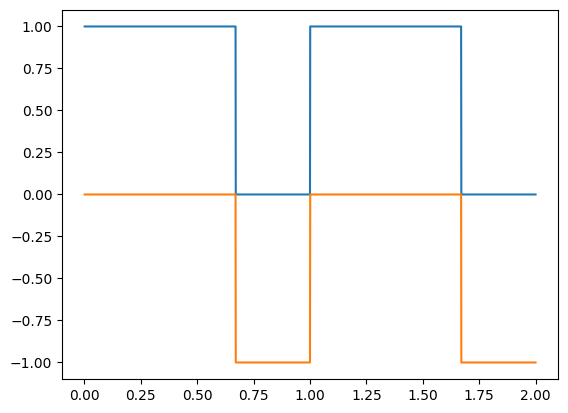

In [8]:
# plt.plot(sim.trange(), sim.data[net.p_cue])
plt.plot(sim.trange(), sim.data[net.p_rew][:,0])
plt.plot(sim.trange(), sim.data[net.p_act][:,0])
